<a href="https://colab.research.google.com/github/vifirsanova/hse-python-course/blob/main/llm_lab/advanced_prompt_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Туториал по промпт-инжинирингу для **LLM Lab**

## 1. Получаем токен на HuggingFace

- Регистрируемся на https://huggingface.co/
- Создаем токен на в настройках аккаунта (выбираем `settings` -> `access tokens` или сразу идем сюда: https://huggingface.co/settings/tokens)
  - важно! тип токена выбираем `read`
- записываем токен в переменную `TOKEN`

**Не храните токен на GitHub!** -- если вы хотите распространить ваш код, предварительно удалите токен из кода

In [ ]:
token = '' # токен начинается с hf_...

## 2. Выбираем модель

- на HuggingFace есть много бесплатных, готовых к использованию языковых моделей
- выбираем их здесь: https://huggingface.co/models?inference=warm&sort=trending
- копируем имя модели, например, `Qwen/QwQ-32B-Preview`

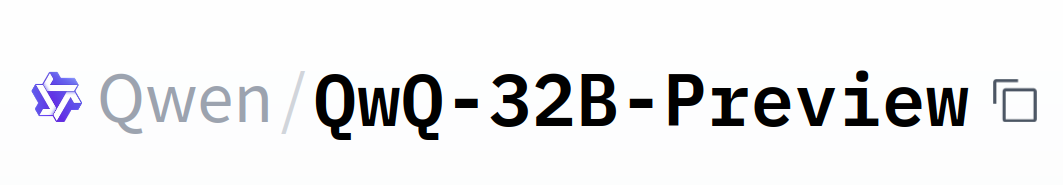

**Рекомендация:** вы можете экспериментировать с разными моделями, но, в целом, достаточно использовать везе `Qwen/Qwen2.5-72B-Instruct`

In [ ]:
model_name = "Qwen/Qwen2.5-72B-Instruct" # здесь можно указать другую модель

## 3. Авторизация клиента

- импортируем `InferenceClient` -- инструмент для получения запросов от модели
- указываем в клиенте название модели и ваш токен

In [ ]:
from huggingface_hub import InferenceClient # импортируем InferenceClient

client = InferenceClient(model_name, token) # загружаем в InferenceClient имя модели и токен, которые мы прописали заранее

## 4. Создаем промпт

Задаем следующие параметры:

- `messages` -- системная роль и промпт для LLM
- `max_tokens` -- максимальная длина вывода (в токенах)
- `temperature` -- температура (рандомность выдачи)
- `top_p` -- также задает рандомность, а именно количество вариантов вывода модели на каждом шаге генерации выдачи

Что мы записываем в `messages`:

- системная роль: основной промпт модели, например, `ты помощник преподавателя` или `генерируй код на Python`
- текущий промпт: можно получать его через input, переменную или аргумент функции и т.д.

Как системная роль, так и текущий промпт допускают использование переменных. В переменную можно записать, например, извлеченный отрывок данных из базы знаний, например, условие задачи, образец решения задания, опорный конспект для генерации ответа и т.д.

Рассмотрим в коде:

In [ ]:
topic = input('Введите тему запроса: ') # здесь мы просим пользователя ввести перменную

client.chat.completions.create( # метод из HuggingFace Cient для осуществления запросов к LLM
          messages=[
              {"role": "system", # маркер системной роли
                "content": "Ты ассистент обучающегося в университете. Объясняй концепты. Используй формат маркированных списков."
              },
              {"role": "user", # маркер текущего промпта пользователя
              "content": f"Объясни основы {topic} простыми словами"},
          ],
          max_tokens=1000, # мы задали максимальную длину ответа -- 1000 токенов, это значение можно увеличить или уменьшить
          temperature=0.5, # temperature можно поменять, например, на 0.6 или 0.7 -- понаблюдайте, окажет ли это влияние на результат
          top_p=0.1 # это значение можно задавать от 0.1 до 0.9 -- также можете понаблюдать за изменениями
          ).choices[0].get('message')['content'] # этот хвостик нам нужен, чтобы вывести только ответ модели без метаданных -- попробуйте удалить его и вывести ответ с метаданными

```
"content": "Ты ассистент обучающегося в университете. Объясняй концепты. Используй формат маркированных списков."
```
Здесь мы описали системную роль модели. Ее можно изменять в зависимости от целевой задача. Наша цель -- вывести такую системную роль, которая поможет нам настроить виртуального ассистента.

---

```
"content": f"Объясни основы {topic} простыми словами"
```

Здесь мы прописали пользовательский промпт. C помощью `f` мы обеспечили возможность добавления переменных в промпт. Здесь в качестве переменной мы прописали `{topic}` -- это значит, что мы можем загружать в этот промпт любые темы.

## 5. Оборачиваем в функцию

Когда мы потестировали разные промпты, можно обернуть все в функцию

In [ ]:
def llm_inference(variable_role, variable_prompt):
  output = client.chat.completions.create(
          messages=[
              {"role": "system", "content": f"Введите сюда системную роль {variable_role}"
              },
              {"role": "user",
              "content": f"Опишите правила для обработки промптов: {variable_prompt}"},
          ],
          stream=False,
          max_tokens=128,
          temperature=0.7,
          top_p=0.1
          ).choices[0].get('message')['content']

  return output

Например, `variable_role` может содержать кусочек из базы знаний,  а `variable_prompt` -- текущий вопрос пользователя

In [ ]:
llm_inference(variable_role, variable_prompt)

## 6. Работа с данными

Сохраняем все промпты, которые вы опробовали и все выдачи в *.csv

Для начала создаем хранилище данных, куда вы запишете результат:

In [ ]:
dataset = {
    "prompts": [], # сюда мы будем добавлять промпты
    "results": [] # сюда будем загружать результаты по этим промптам
}

Задаем промпт

In [ ]:
variable_role = "это системная роль, которую я хочу протестировать"
variable_prompt = "это пользовательский промпт, который я хочу протестировать"

Теперь сохраним промпт и результаты в переменные:

In [ ]:
prompt = (variable_role, variable_prompt)
result = llm_inference(prompt)

Добавим результаты в наше хранилище:

In [ ]:
dataset["prompts"].append(prompt)
dataset["results"].append(result)

Эти ячейки можно прогонять множество раз, либо прописать цикл.

Как только вы закончили пополнять датасет, посмотрите на него глазками:

In [ ]:
from pprint import pprint

pprint(dataset)

Теперь можно сохранить результат в *.csv

In [ ]:
import pandas as pd

df = pd.DataFrame(dataset)
df.head() # посмотрим на датасет

Сохраняем и скачиваем датасет

In [ ]:
df.to_csv('data_surname.csv') # добавьте свою фамилию вместо surname

Загрузите результат в репозиторий

1. https://github.com/vifirsanova/hse-assistant - команда "Виртуальный ассистент"
2. https://github.com/vifirsanova/synth-dataset - команда "Синтетический датасет"

Если вы ранее не работали с гитом:

1. Регистрируем на Githb
2. Переходим по ссылке с репозиторием
3. `fork`

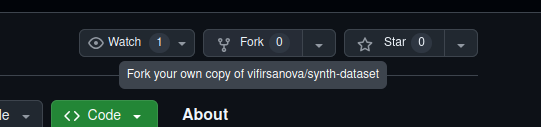


4. `Create fork`

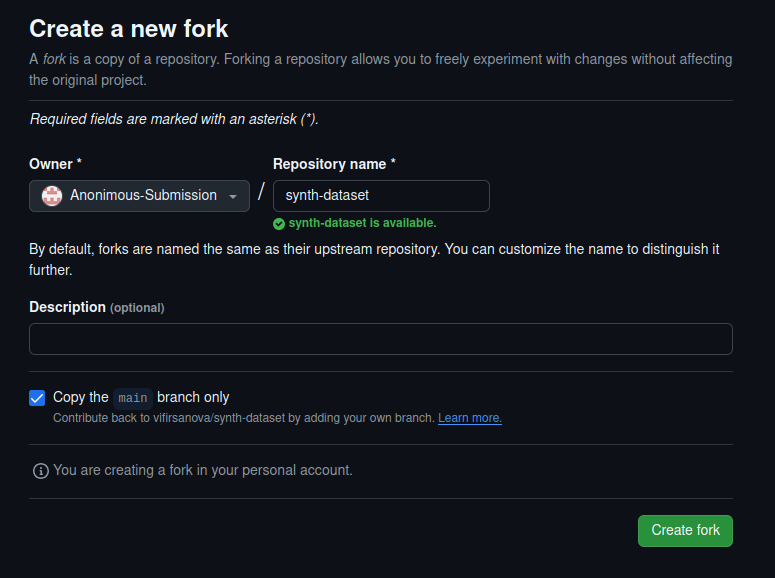

5. Далее у вас создается новый `forked repository`: `upload files`

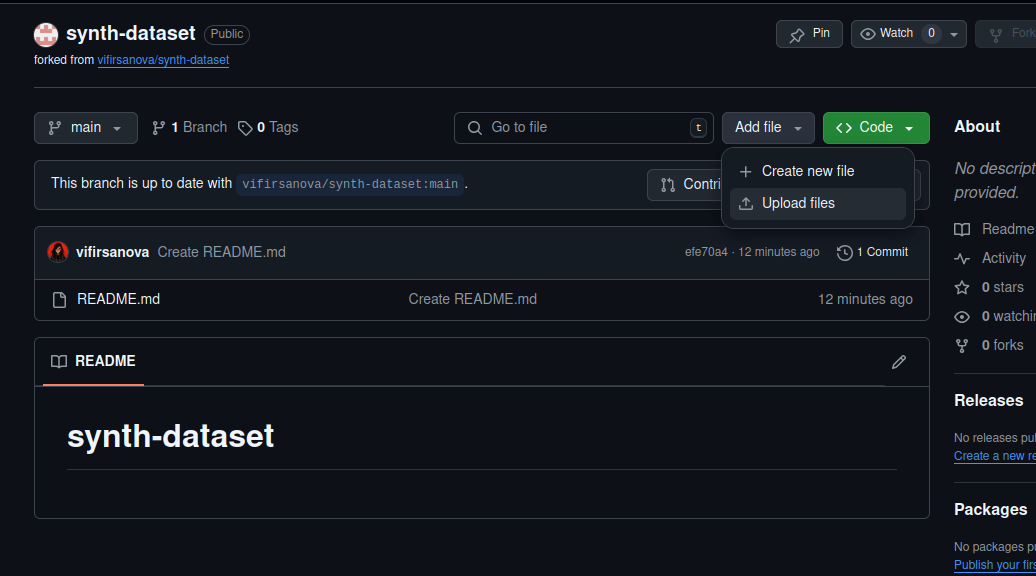

6. Подгружаем ваш *.csv --> важно! выбираем `Create a new branch...` и жамкаем `Propose changes`

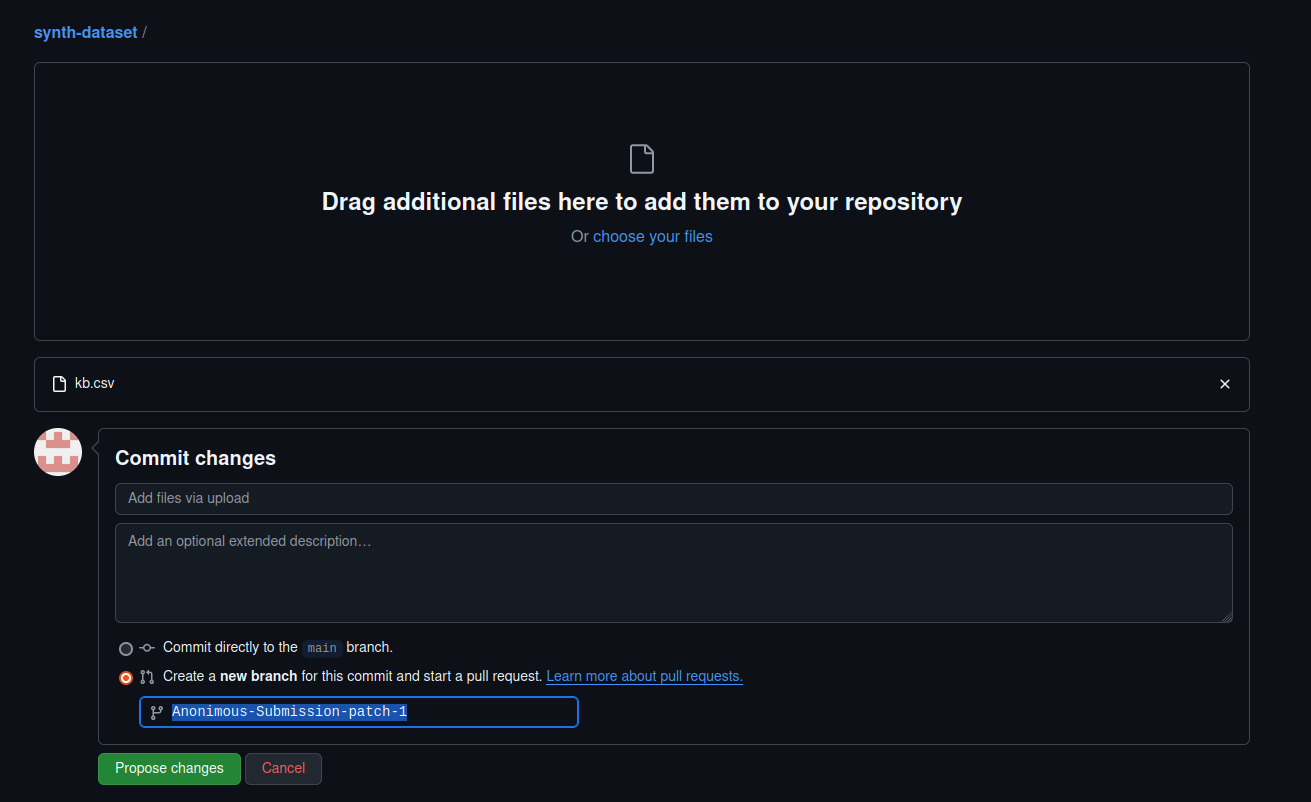

7. `Create pull request`

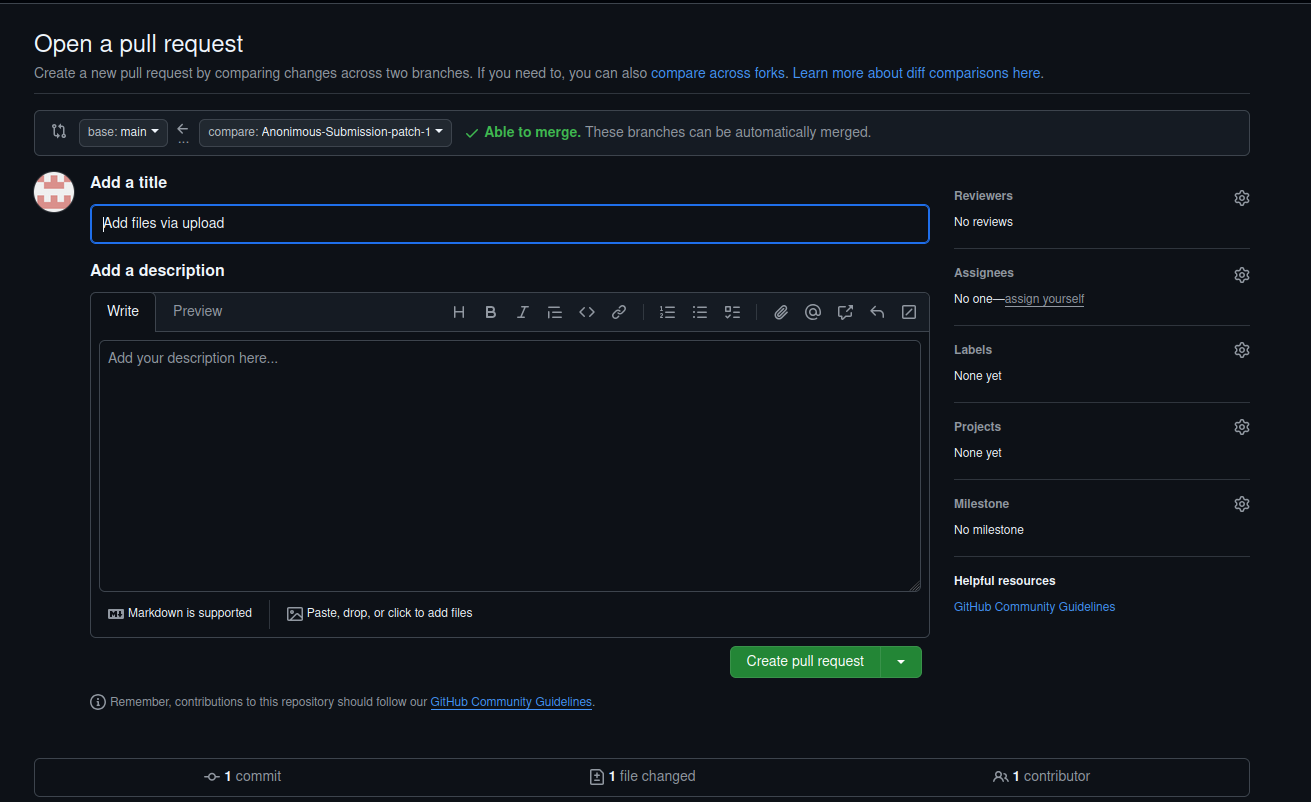

8. `Merge pull request`

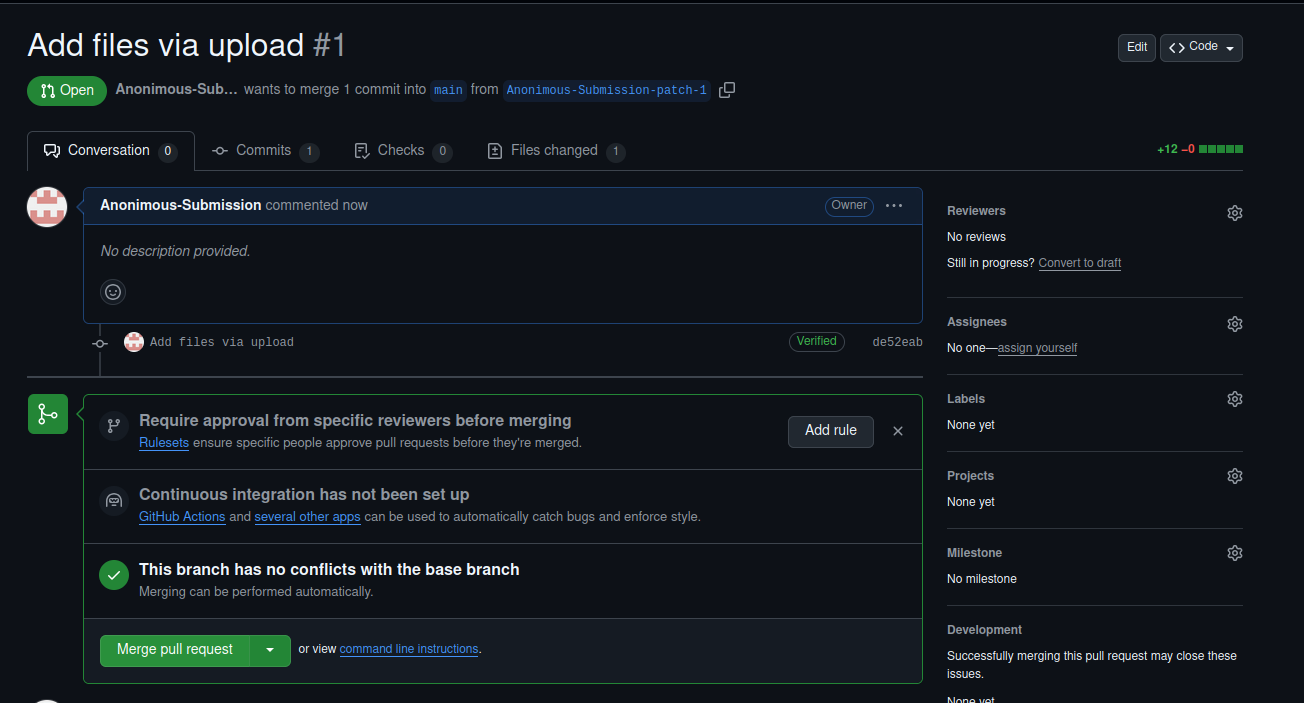

9. `Confirm merge`

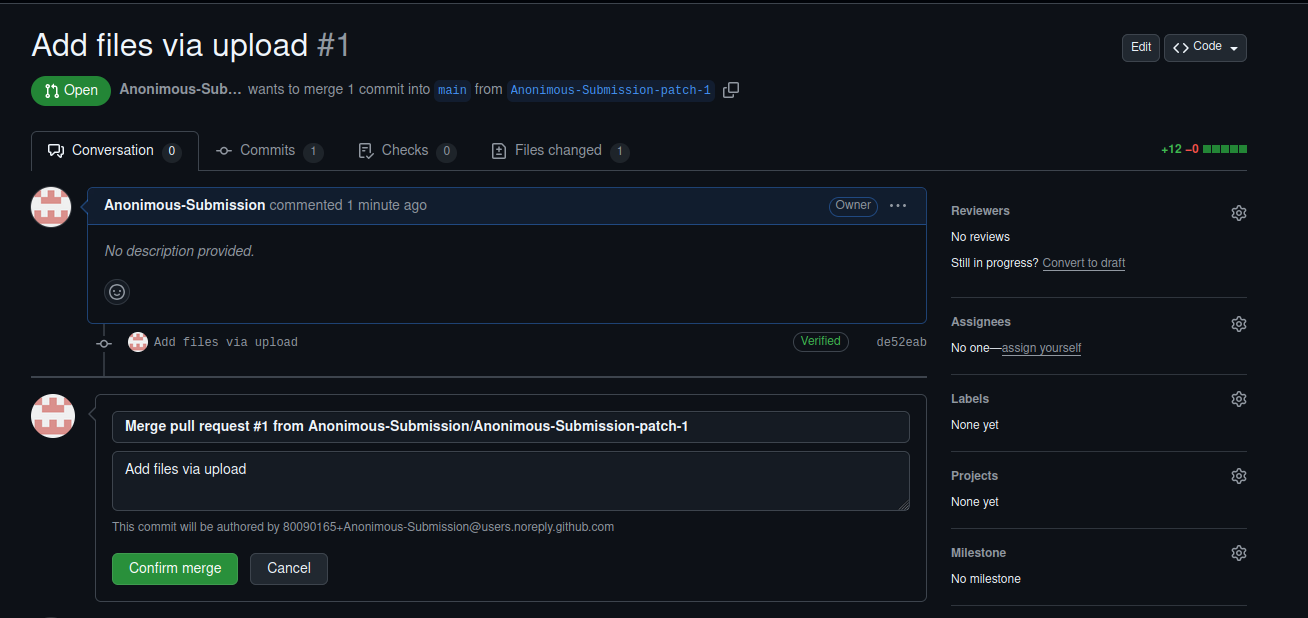

10. `Open pull request`

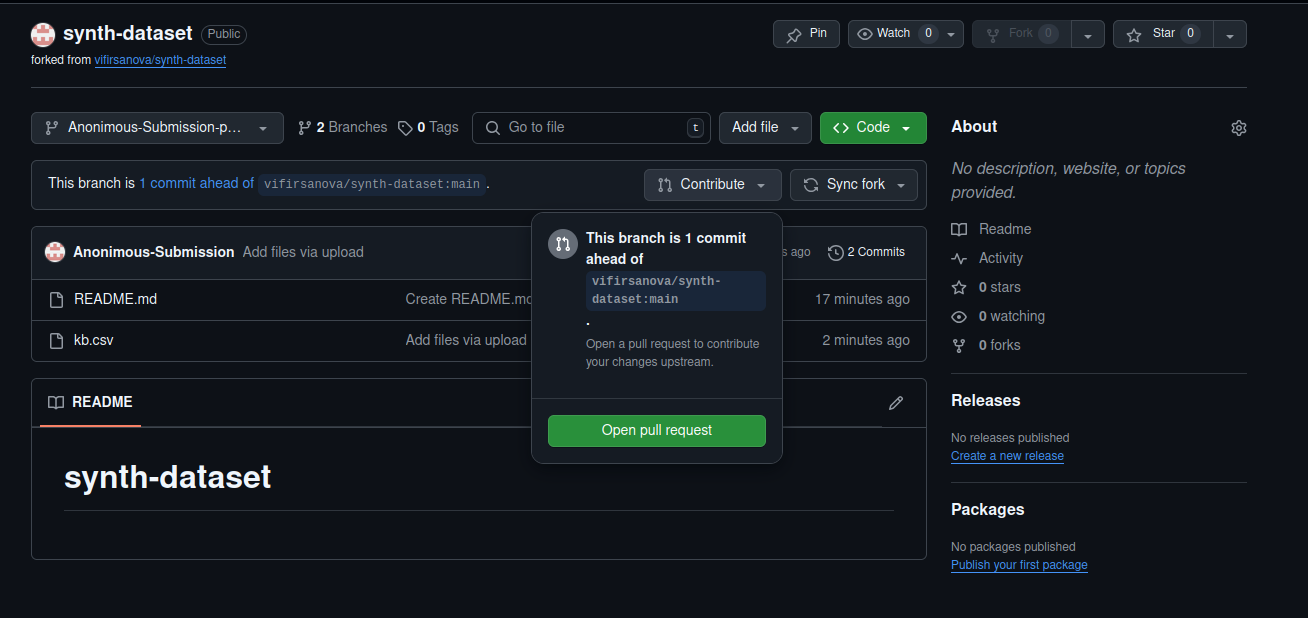

Результат можно будет увидеть здесь

- https://github.com/vifirsanova/synth-dataset/pulls
- https://github.com/vifirsanova/hse-assistant/pulls

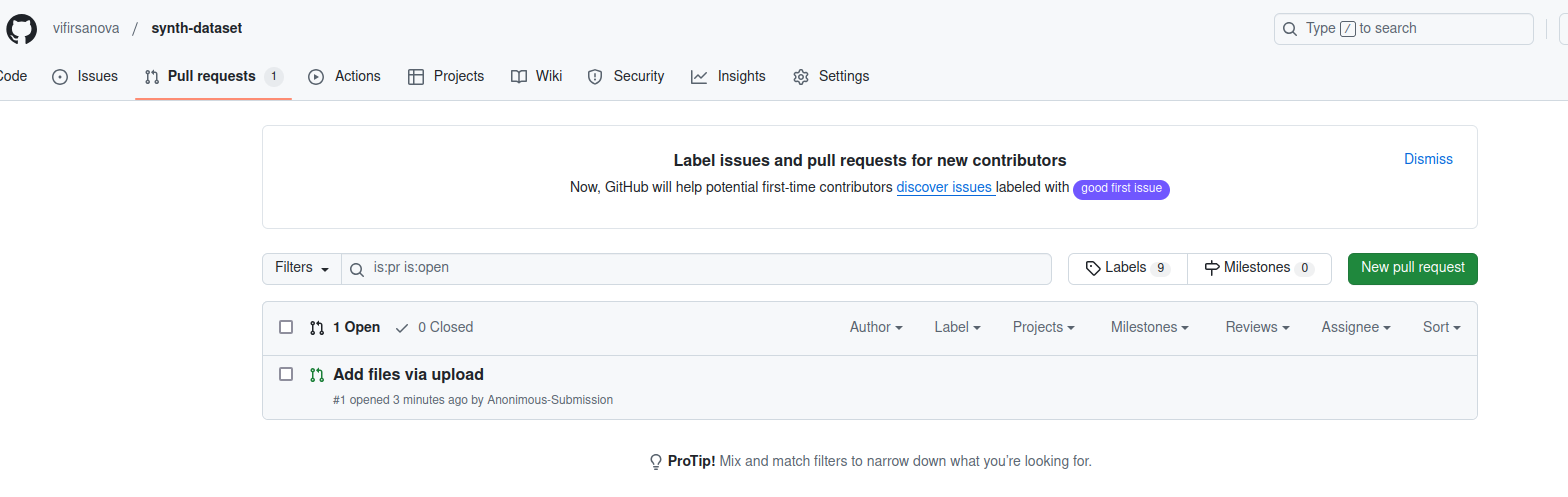